Import packages

In [1]:
from ptufile import PtuFile
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog


Check number of TCSPC channel bins in all .ptu files in a directory

It is rather surprising that the number of bins is somewhat random. As the settings did not change, nor should the number of channels

root = tk.Tk()
root.withdraw()  # Hide the root window

folder_path = filedialog.askdirectory(title = "Select directory")
root.destroy()

import os
ptu_files = [f for f in os.listdir(folder_path) if f.endswith('.ptu')]

for f in ptu_files:
    ptu=PtuFile(os.path.join(folder_path,f))
    print(f,ptu.shape[4])

User input - get file path

In [2]:
# Create Tkinter root window
root = tk.Tk()
root.withdraw()  # Hide the root window

# Open file dialog and get selected file
file_path = filedialog.askopenfilename(title="Select file",filetypes=[('PicoQuant PTU file', '*.ptu')])
root.destroy()


Read PTU properties from the file for inspection

In [3]:
ptu=PtuFile(file_path)
print("PTU file type: ", ptu.type)
print("Record type: ", ptu.record_type)
print("Measurement mode: ", ptu.measurement_mode)
print("Measurement submode: ", ptu.measurement_submode)
print("Dimensions names: " , ptu.dims) # 'T' is for frames, i.e., time lapse or z-stack. The latter in our case, 'H' - TCSPC channels
print("Image shape: " , ptu.shape)

# print(ptu.coords)
print("Data type: " , ptu.dtype)
print("Active channels: " , ptu.active_channels)
print("Resolution: ", ptu.tcspc_resolution * 1e12 , " ps")
print("Number of markers: ", ptu.number_markers)
print("Number of frames: ", ptu.number_images)
print("Number of lines: ", ptu.number_lines)

file_path

PTU file type:  PqFileType.PTU
Record type:  16843524
Measurement mode:  3
Measurement submode:  3
Dimensions names:  ('T', 'Y', 'X', 'C', 'H')
Image shape:  (5, 400, 100, 2, 5090)
Data type:  uint16
Active channels:  (0, 1)
Resolution:  5.0  ps
Number of markers:  2248
Number of frames:  5
Number of lines:  2000


'C:/Users/dalibor/Data/2025-03-13_Buchel/1856/MultiHarp150_2025-03-13_11-10-28.ptu'

Read the image

In [4]:
I = ptu.decode_image(asxarray=True)
print("Raw image shape: " , I.shape)
print("Image data class: " , I.__class__)
# print(I["T"]) # only for xarray

Raw image shape:  (5, 400, 100, 2, 5090)
Image data class:  <class 'xarray.core.dataarray.DataArray'>


Process the raw image - apply line binning, z-projection and TCSPC binning

In [5]:
line_bin = 4
time_points = 5
tcspc_bin = 8 # target resolution is 40 ps. We used 40 or 5 ps sometimes
I_binned = I.coarsen(Y=line_bin, T=4, H=tcspc_bin, boundary="trim").sum().astype(np.uint16)
I_binned = I_binned.isel(C=1).squeeze() # select second channel only (donor)
time_calibration = tcspc_bin * ptu.tcspc_resolution * 1e9 # channel duration in ns
#  get time bins in ns
time_bins = I_binned['H'] * 1e9

print("Processed image shape: " , I_binned.shape)
print("TCSC channel width: ", time_calibration, "ns")

Processed image shape:  (100, 100, 636)
TCSC channel width:  0.04 ns


Plot TCSPC histogram of the second channel (acceptor)

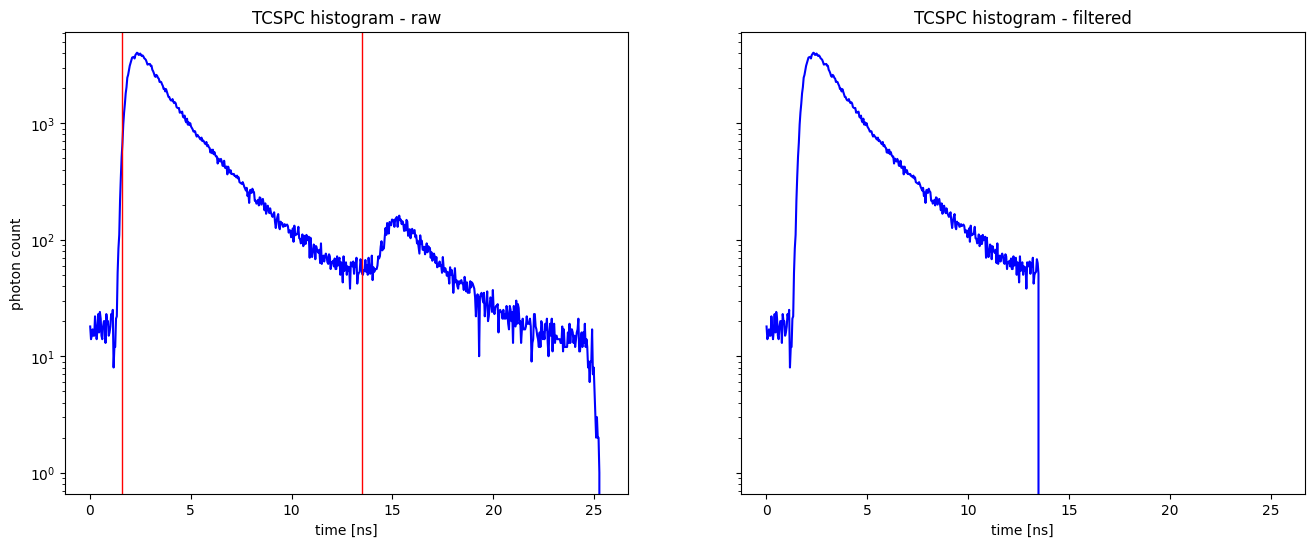

In [7]:
shift = 1.6 # delay of the laser pulse
cut_off = 13.5 # number of channel to cut off the decay to get rid of the reflection

fig, axes = plt.subplots(1,2, figsize=(16, 6), sharey=True)
axes[0].semilogy(time_bins, I_binned.sum(dim=['X','Y'],skipna=True), color = 'blue')
axes[0].axvline(shift, color = 'red', linewidth = 1)
axes[0].axvline(cut_off, color = 'red', linewidth = 1)
axes[0].set_title('TCSPC histogram - raw')
axes[0].set_xlabel('time [ns]')
axes[0].set_ylabel('photon count')

# filter the image - cut off the reflection in the decay
I_binned_filtered = I_binned.where(I_binned.coords["H"] <= cut_off * 1e-9, other=0)
axes[1].semilogy(time_bins, I_binned_filtered.sum(dim=['X','Y'],skipna=True), color = 'blue')
axes[1].set_xlabel('time [ns]')
axes[1].set_title('TCSPC histogram - filtered')


plt.show()



Calculate array of mean photon arrival times

In [8]:
# Perform the weighted sum and total sum
weighted_time_sum = (I_binned * time_bins).sum(dim='H')
total_photon_count = I_binned.sum(dim='H')

# Final result (avoid divide-by-zero)
mean_photon_arrival_time = xr.where(
    total_photon_count > 0,
    weighted_time_sum / total_photon_count,
    0
) - shift


Plot mean photon arrival time histogram of the image

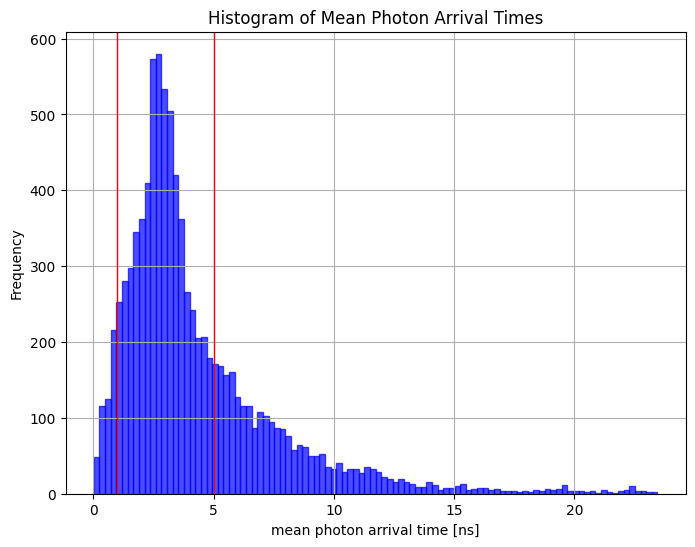

In [9]:
lt_min, lt_max = 1 , 5 # limits for lifetime display

plt.figure(figsize=(8, 6))
# pat_np = mean_photon_arrival_time.values * time_calibration
# plt.hist(pat_np.flatten(), bins=100, color='blue', edgecolor='blue', alpha=0.7)
flat_data = mean_photon_arrival_time.values.flatten()
flat_data = flat_data[~np.isnan(flat_data) & (flat_data > 0)]

plt.hist(flat_data, bins = 100, color= 'blue', edgecolor = 'blue', alpha = 0.7)
plt.axvline(lt_min, color = 'red', linewidth = 1)
plt.axvline(lt_max, color = 'red', linewidth = 1)
plt.title('Histogram of Mean Photon Arrival Times')
plt.xlabel('mean photon arrival time [ns]')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [10]:
from scipy.ndimage import gaussian_filter
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Smooth LT with Gaussian filter
n = 0  # Smoothing kernel size (sigma), 0 = no smoothing

LT_smoothed = gaussian_filter(mean_photon_arrival_time, sigma=n)

# Normalize LT values for colormap mapping
LT_normalized = (LT_smoothed - lt_min) / (lt_max - lt_min)  # Scale to [0,1]

# Convert LT values to RGB using a colormap (e.g., "jet", "viridis", "turbo")
colormap = cm.rainbow  # Change colormap if needed
# Create a custom colormap from Green to Magenta
# colormap = mcolors.LinearSegmentedColormap.from_list("green_magenta", [(0,1,0), (1,0,1)])
# colormap = mcolors.LinearSegmentedColormap.from_list("cyan_red", ["cyan", "red"])


# LT_rgb = colormap(LT_normalized)[..., :3]  # Get RGB (ignore alpha channel)
LT_rgb = colormap(LT_normalized)[..., :3]


# Normalize Intensity and scale RGB by it
intensity_normalized = total_photon_count.values / total_photon_count.values.max()  # Scale to [0,1]
FLIM_image = LT_rgb * intensity_normalized[..., np.newaxis]   # Apply intensity



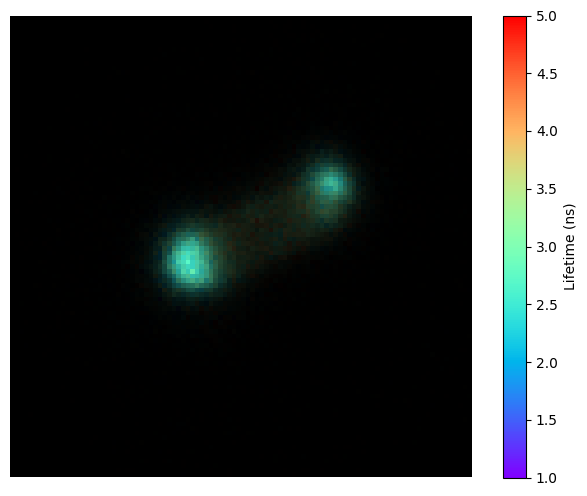

In [11]:
plt.figure(figsize=(8, 6))
img = plt.imshow(FLIM_image, cmap=colormap, vmin=lt_min, vmax=lt_max)
plt.axis("off")
# plt.title("FLIM Image (Lifetime + Intensity)")


# Add colorbar
plt.colorbar(img, label="Lifetime (ns)")

plt.show()